In [2]:
import pandas as pd
import numpy as np
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.column_space', 30)
pd.set_option('display.date_dayfirst', True)
pd.set_option('display.max_seq_items', 10000)
pd.options.display.float_format = '{:20,.2f}'.format
import re
import json
import pprint as pp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
def parse_db(res):
    res1 = {}
    id=0
    
    with open(res,encoding='ISO-8859-15') as file: 
        db = file.read()
        
    for resource in db.split(';\n\n'):
        res2 = {}
        for attribute in [i.strip() for i in resource.split(';\n')]:
            try: name,value = [i.strip() for i in re.split(':',attribute,maxsplit=1,flags=re.M)]
            except ValueError: value += attribute
            res2[name] = re.sub('\\\n','',value)
        id+=1
        res1[id] = res2
        
    return pd.read_json(json.dumps(dict(res1)),orient='index')

In [4]:
def parse_log(res):
    columns=['pnum','day','time','id1','id2','id3','id4','id5','id6','server','program','nsr','level','log']
    dtypes={'id1':np.int32,'id2':np.int32,'id3':np.int32,'id4':np.int32,'id5':np.int32,'id6':np.int32}

    with open(res,'r') as file:
        with open(res + ".csv",'w') as log:
            for line in file:
                m = re.split('\s+',line)
                line = '&'.join(m[:13]) + '&' + ' '.join(m[13:]) + '\n'
                log.write(line)

    log = pd.read_csv(res + ".csv",sep='&',names=columns,error_bad_lines=False,
                        parse_dates={'date':[1,2]})
    log.index = pd.to_datetime(log.date, format='%m/%d/%y %H:%M:%S',errors='raise')
    log.drop('date',axis=1,inplace=True)
    return log

In [187]:
def parse_mminfo(res):
    convert = {'B':1,'KB': 1e3,'MB':1e6,'GB':1e9,'TB':1e12}
    with open(res,'r') as file:
        with open(res + ".csv",'w') as log:
            for line in file:
                m = re.split('\s+',line)
                line = '&'.join(m[:11]) + '&' + ' '.join(m[11:]) + '\n'
                log.write(line)

    log = pd.read_csv(res + ".csv",sep='&',error_bad_lines=False,
                        parse_dates={'date2':[4,5]},dayfirst=True)
    #log.index = pd.to_datetime(log.date2, format='%m/%d/%y %H:%M:%S',errors='coerce')
    log['size'] = log.apply(lambda row: row.size1*convert[row.size2], axis=1)
    log.drop(['type1','type2','size1','size2'],axis=1,inplace=True)
    log.rename({'date2':'date'},axis=1,inplace=True)
    log.rename({'sset ':'sset'},axis=1,inplace=True)
    del log.index.name
    return log

# NSRDB

In [6]:
nsrdb = parse_db('DC1-NTW01_nsrdb.out')
exclude = ['name','type','ONC program number','ONC transport','ONC version number']
writer = pd.ExcelWriter('nsrdb.xlsx')
for nsrtype in nsrdb.type.dropna().unique():
    res = nsrdb[nsrdb.type==nsrtype].dropna(axis=1)
    filter = ['name'] + [col for col in res.columns.tolist() if col not in exclude]
    res[filter].to_excel(writer,nsrtype,index=False)
writer.save()
print(nsrdb.type.unique())

[nan 'NSR pool' 'NSR client' 'NSR policy' 'NSR schedule' 'NSR device'
 'NSR group' 'NSR directive' 'NSR stage' 'NSR label' 'NSR notification'
 'NSR usergroup' 'NSR recover' 'NSR lockbox' 'NSR Snapshot Policy'
 'NSR Storage Node' 'NSR license' 'NSR auditlog' 'NSR client fix'
 'NSR jukebox' 'NSR task' 'NSR' 'NSR Report Home' 'NSR operation status'
 'NSR hypervisor' 'NSR NAS discovery task']


In [7]:
vols = nsrdb[nsrdb.type=="NSR jukebox"].dropna(axis=1).volumes.values[0].split(',')
vols = [vol.strip() for vol in vols]
len(vols)

2950

# JOBSDB

In [8]:
jobsdb = parse_db("jobquery.txt")
writer = pd.ExcelWriter('jobsdb.xlsx')
for nsrtype in jobsdb.type.dropna().unique():
    res = jobsdb[jobsdb.type==nsrtype].dropna(axis=1)
    res.to_excel(writer,nsrtype,index=False)
writer.save()
print(jobsdb.type.unique())

['active job db' 'bootstrap save job' 'index save job' 'job indication'
 'notification job' 'recover pipe to save job' 'save job' 'savefs job'
 'savegroup job' 'session info' 'synthetic full job' 'utility job']


In [9]:
groups = jobsdb[jobsdb.type=="savegroup job"].dropna(axis=1)[['name','start time','end time', 'completion status']].groupby('name').first()
groups['start time'] = groups['start time'].astype(int,errors='ignore')
groups['end time'] = groups['end time'].astype(int,errors='ignore')
groups['duration'] = groups['end time'] - groups['start time']
groups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, APPLI_ACTES to VADP_RH
Data columns (total 4 columns):
start time           31 non-null int64
end time             31 non-null int64
completion status    31 non-null object
duration             31 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.2+ KB


In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(grps))
ax.barh(y_pos, groups.duration, left=groups['start time'], align='center', color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(groups.index)
start = pd.to_datetime(groups['start time'].min(),unit='s')
end = pd.to_datetime(groups['end time'].max(),unit='s')
ax.set_xticklabels(pd.date_range(start, end, freq='H'), rotation=45)
plt.show()

# MMINFO

In [188]:
mminfo = parse_mminfo("mminfo.txt")
mminfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10097 entries, 0 to 10096
Data columns (total 8 columns):
date      10097 non-null datetime64[ns]
volume    10097 non-null object
client    10097 non-null object
ssid      10097 non-null int64
flags     10097 non-null object
level     10097 non-null object
sset      10097 non-null object
size      10097 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 631.1+ KB


In [ ]:
filter = ((mminfo.level=='full'))
mminfo[filter].groupby(['client','sset'])['size'].max().apply(lambda x: x/1e9).nlargest(10)

In [ ]:
filter = ((mminfo.level=='full') & (mminfo.sset.str.contains('FULLVM')))
mminfo[filter].groupby(['client'])['size'].mean().apply(lambda x: x/1e9).nlargest(10)

In [245]:
res1 = mminfo[mminfo.level=='full'].resample('D',on='date')['size'].sum()
res2 = mminfo[mminfo.level!='full'].resample('D',on='date')['size'].sum()

dailysize = pd.concat([res1,res2],axis=1) / 1e12
dailysize.columns = ['full','incr']

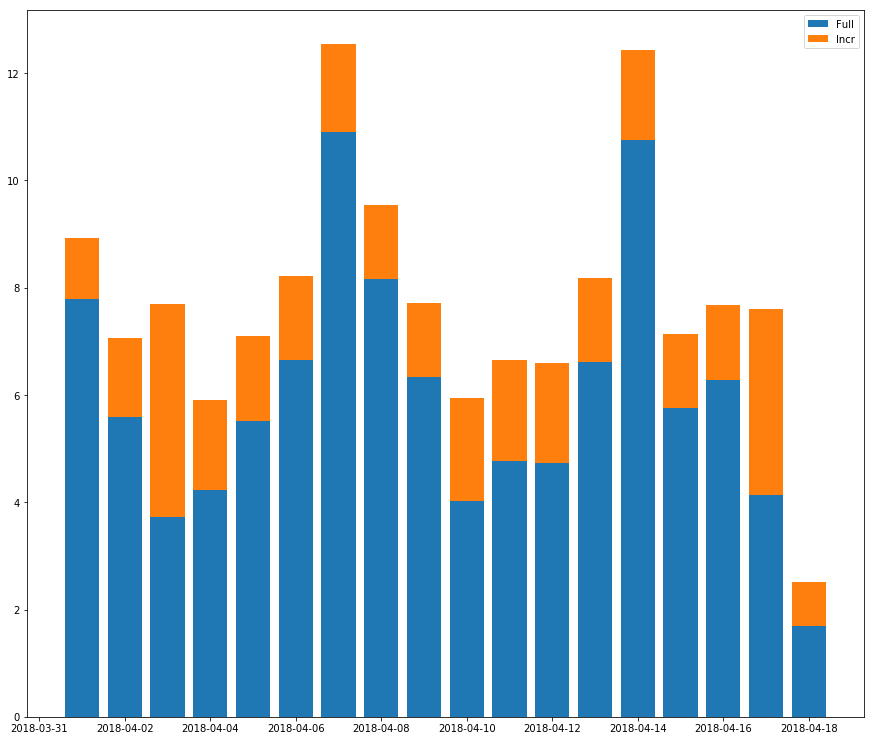

In [244]:
fig = plt.figure(figsize=(15,13))
ax1 = fig.add_subplot(111)
ax1.bar(dailysize.index,dailysize.full)
ax1.bar(dailysize.index,dailysize.incr,bottom=dailysize.full)
plt.legend(('Full', 'Incr'))
plt.show()

# MMPOOL

In [112]:
mmpool = pd.read_csv("mmpool.txt",sep=',')
mmpool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 2 columns):
volume    2947 non-null object
pool      2946 non-null object
dtypes: object(2)
memory usage: 46.1+ KB


In [215]:
res = mmpool.groupby('pool').count()
pd.concat([res, res * 104 / 1e3],axis=1)

,volume,volume
pool,,
1 mois,1426,148.30
15 jours,1457,151.53
7 jours,33,3.43
Default,30,3.12


# DAEMONLOG

In [12]:
log = parse_log("daemon.logs/2/lastlog")
log.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87877 entries, 2018-03-27 17:00:07 to 2018-04-10 13:04:25
Data columns (total 12 columns):
pnum       87877 non-null int64
id1        87877 non-null int64
id2        87877 non-null int64
id3        87877 non-null int64
id4        87877 non-null int64
id5        87877 non-null int64
id6        87877 non-null int64
server     87877 non-null object
program    87877 non-null object
nsr        87877 non-null object
level      87877 non-null object
log        87877 non-null object
dtypes: int64(7), object(5)
memory usage: 8.7+ MB


In [13]:
log.program.unique()

array(['nsrd', 'nsrexecd', 'nsrmmdbd', 'nsrdispd', 'nsrjobd', 'nsrindexd',
       'nsrmmgd', 'nsrsnmd', 'nsrvmwsd', 'nsrlcpd#1', 'nsrmmd', 'nsrpsd',
       'savegrp', 'nsrtask', 'nsrdisp_nwbg', 'nsrim'], dtype=object)

## groups

In [14]:
filter = (log.program=='nsrd') & (log.log.str.contains("Starting the group"))
started = log.log[filter].reset_index()
started[['group','clients']] = started.log.str.split(' ',expand=True)[[5,8]]
started.group = started.group.apply(lambda x: re.sub('[\',.]','',x))
started.drop('log',axis=1,inplace=True)
started.rename({'date':'started'},axis=1,inplace=True)
started['session'] = started.groupby('group').cumcount()

range_session = {g:0 for g in started.group.unique()}

def calcul_session(row):
    start = started[started.group==row.group].iloc[0]
    if start.started > row.completed: res =  -1  
    else:
        res = range_session[row.group]
        range_session[row.group]+=1
    return res

r_clients = re.compile('Total (\d+) client\(s\)')
r_Unresolved = re.compile('(\d+) Hostname\(s\) Unresolved')
r_Warnings = re.compile('(\d+) Succeeded with warning\(s\)')
r_Succeeded = re.compile('(\d+) Succeeded')
r_Failed = re.compile('(\d+) Failed')

def parse_savegrouplog(row):
    for line in row.log.split(','):
        line = line.strip()
        res = re.match(r_clients,line)
        if res: row['Clients'] = int(res.group(1))
        res = re.match(r_Unresolved,line); 
        if res: row['Unresolved'] = int(res.group(1))
        res = re.match(r_Warnings,line)
        if res: row['Warnings'] = int(res.group(1))
        res = re.match(r_Succeeded,line)
        if res: row['Succeeded'] = int(res.group(1))
        res = re.match(r_Failed,line)
        if res: row['Failed'] = int(res.group(1))
    return row

filter = (log.program=='nsrd') & ((log.log.str.contains("completed,")) | (log.log.str.contains("aborted,")) | (log.log.str.contains("terminée,")))
completed = log.log[filter].str.split('notice:|alert:|Alert:|completed,|aborted,|terminée,|\.',expand=True).reset_index()
completed = completed[['date',0,1,2]].rename({'date':'completed',0:'type',1:'group',2:'log'},axis=1)
completed[['type','group']] = completed[['type','group']].apply(lambda x: x.str.strip(),axis=1)
completed = completed[completed.type=="savegroup"].reset_index(drop=True)
completed.drop(completed[completed.log.str.contains("already running")].index,inplace=True)
completed = completed.apply(parse_savegrouplog,axis=1).fillna(0)
completed['session'] = completed.groupby('group').cumcount()
#completed['session'] = completed.apply(calcul_session,axis=1)

groups = pd.merge(started,completed,how='left',on=['group','session'])
#groups = pd.concat([started,completed],axis=1)
groups['duration'] =  groups.completed - groups.started

grp = pd.DataFrame(groups.group.unique()).reset_index().rename({'index':'num',0:'group'},axis=1)
groups = pd.merge(groups,grp,how='left',on='group')
#groups = groups[~groups.completed.isna()]
groups['ratio'] = groups.Failed/groups.Clients
groups = groups[['session','num','group','started','completed','duration','Clients','Failed','Succeeded','Unresolved','Warnings','ratio']]


# filter = (log.program=='nsrd') & (log.log.str.contains("savegroup alert"))
# res = log.log[filter].str.split('alert:|completed,|aborted,|terminée,|\.',expand=True).reset_index()
# res = res[['date',1,2]].rename({1:'group',2:'log'},axis=1)
# res = res.apply(parse_savegrouplog,axis=1).fillna(0)

# groups = pd.merge(groups,res,how='left',left_on=['group','completed'],right_on=['group','date'])

### Percent failed

In [267]:
groups.groupby('group').ratio.mean().nlargest(10)

group
APPLI_ACTES                            0.18
APPLI_REFERENCE_TEST                   0.13
APPLI_FICHIERS                         0.05
VADP_Infra                             0.04
VADP_MINFRA                            0.03
VADP_DEMAT                             0.02
APPLI_RH                               0.02
VADP_BO                                0.01
VADP_REFERENCE_TEST                    0.01
APPLI_ACTES_TEST                       0.00
Name: ratio, dtype: float64

In [270]:
round(groups.groupby('group').ratio.mean().sum() / len(groups.group.unique()) * 100,1)

1.5

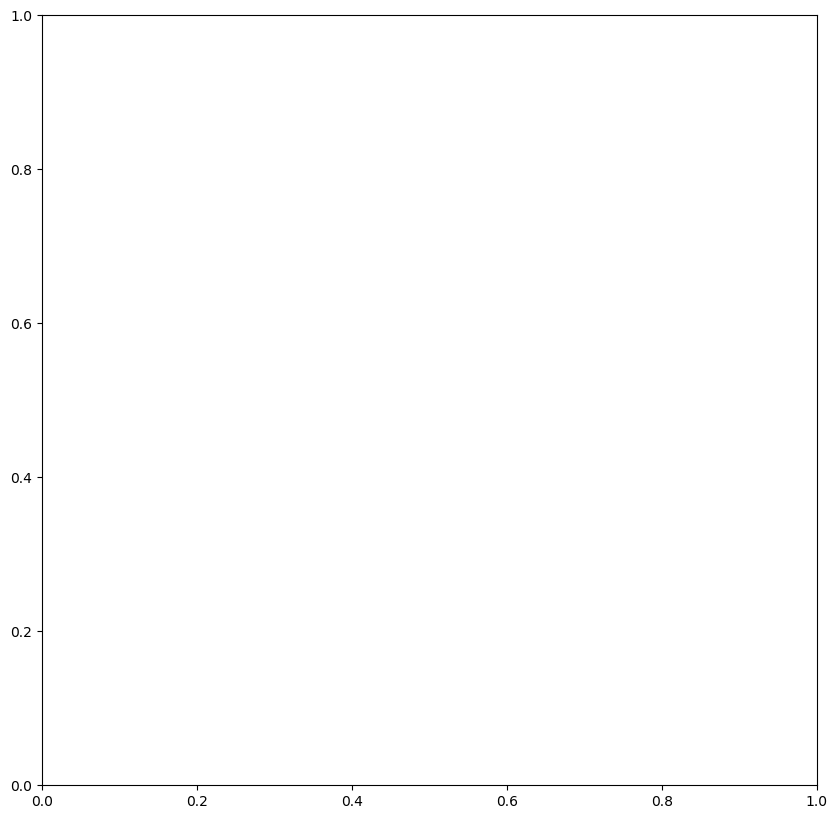

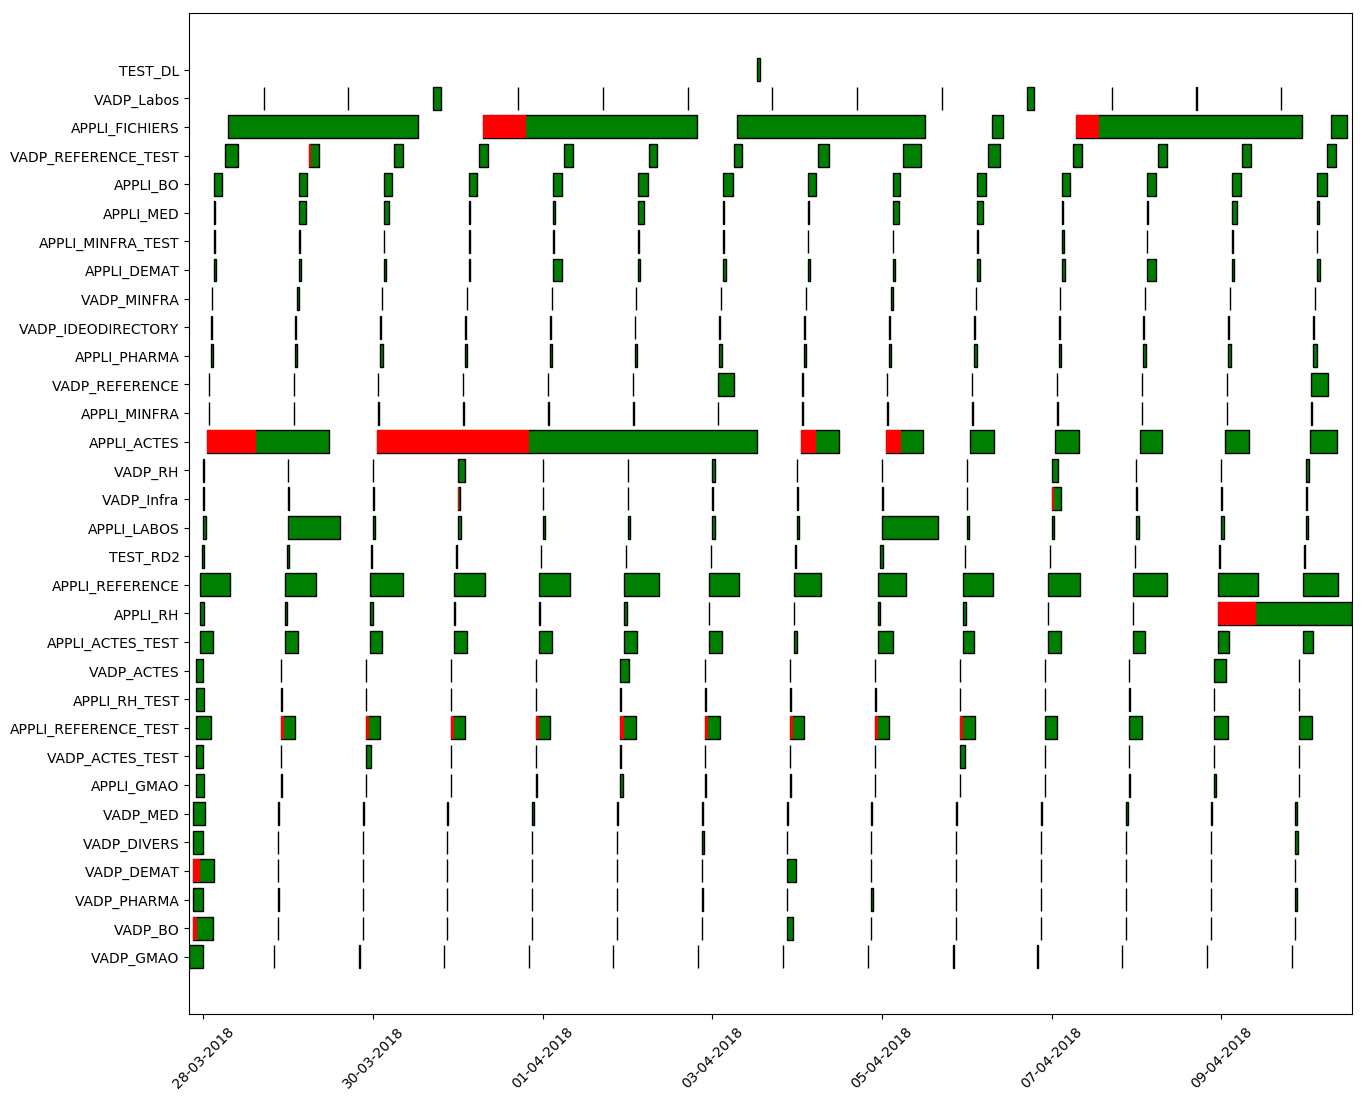

In [17]:
fig = plt.figure(figsize=(15,13))
ax1 = fig.add_subplot(111)

grplist = groups.groupby('group').num.first().sort_values().reset_index()

xtick = pd.date_range(groups.started.min(), groups.completed.max(), freq='D')
daysFmt = mdates.DateFormatter('%d-%m-%Y')
ax1.set_yticks(grplist.num)
ax1.set_yticklabels(grplist.group)
ax1.set_xlim(groups.started.min(), groups.completed.max())
ax1.set_xticklabels(xtick,rotation=45)
ax1.xaxis.set_major_formatter(daysFmt)
for i in range(len(groups.session)):
    grp = groups[groups.session==i]
    ax1.barh(grp.num, grp.duration, left=grp.started, color='green',edgecolor='black')
    ax1.barh(grp.num, grp.duration*grp.ratio, left=grp.started, color='red')

plt.show()

## errors

In [ ]:
for level in log.level[log.level.notna()].unique():
    print('-'*10 + level + '-'*10)
    print(log.log[log.level==level].value_counts()[:10].reset_index())

### waiting volume

In [19]:
filter = ((log.log.str.contains("Media Critical event")) & (~log.log.str.contains("LTO Ultrium-4")))
tapes = log.log[filter].str.split(':|[Ww]aiting for|writable|tape|\'',expand=True)
tapes = tapes[[2,4]].rename({2:'waiting',4:'pool'},axis=1)
tapes['waiting'] = tapes.waiting.astype(int)

In [20]:
tapes.resample('H').sum()

,waiting
date,
2018-03-27 20:00:00,1
2018-03-27 21:00:00,103
2018-03-27 22:00:00,435
2018-03-27 23:00:00,1095
2018-03-28 00:00:00,163


### drives

In [106]:
daterange = (log.index > '03/31/18 16:00') & (log.index < '04/6/18 16:00')
filter = ( daterange &(log.program=='nsrmmgd') & (log.log.str.contains("Loading")))
loading = log.log[filter].str.split('volume|\'|\`',expand=True).reset_index()
loading = loading[['date',2,6]].rename({'date':'loading',2:'tape',6:'drive'},axis=1)
loading[['tape','drive']] = loading[['tape','drive']].apply(lambda x: x.str.strip(),axis=1)
loading['session'] = loading.groupby('drive').cumcount()

range_session = {g:0 for g in loading.drive.unique()}

def calcul_session(row):
    start = loading[loading.drive==row.drive].iloc[0]
    if start.loading > row.unloading: res =  -1  
    else:
        res = range_session[row.drive]
        range_session[row.drive]+=1
    return res

filter = (daterange & (log.program=='nsrmmgd') & (log.log.str.contains("Unloading")))
unloading = log.log[filter].str.split('volume|\'|\`',expand=True).reset_index()
unloading = unloading[['date',2,4]].rename({'date':'unloading',2:'tape',4:'drive'},axis=1)
unloading[['tape','drive']] = unloading[['tape','drive']].apply(lambda x: x.str.strip(),axis=1)
#unloading['session'] = unloading.groupby('drive').cumcount()
unloading['session'] = unloading.apply(calcul_session, axis=1)

drives = pd.merge(loading,unloading,how='left',on=['drive','session'])
drives['duration'] = drives.unloading - drives.loading
#drives['session'] = drives.groupby('drive').cumcount()

drvlist = pd.DataFrame(drives.drive.unique()).sort_values(by=0).reset_index()
drvlist = drvlist.rename({'index':'num',0:'drive'},axis=1)

drives = pd.merge(drives,drvlist,how='left',on='drive')

#filter = (drives.duration > pd.Timedelta(np.timedelta64(1, 'm')))
drives = drives.dropna()

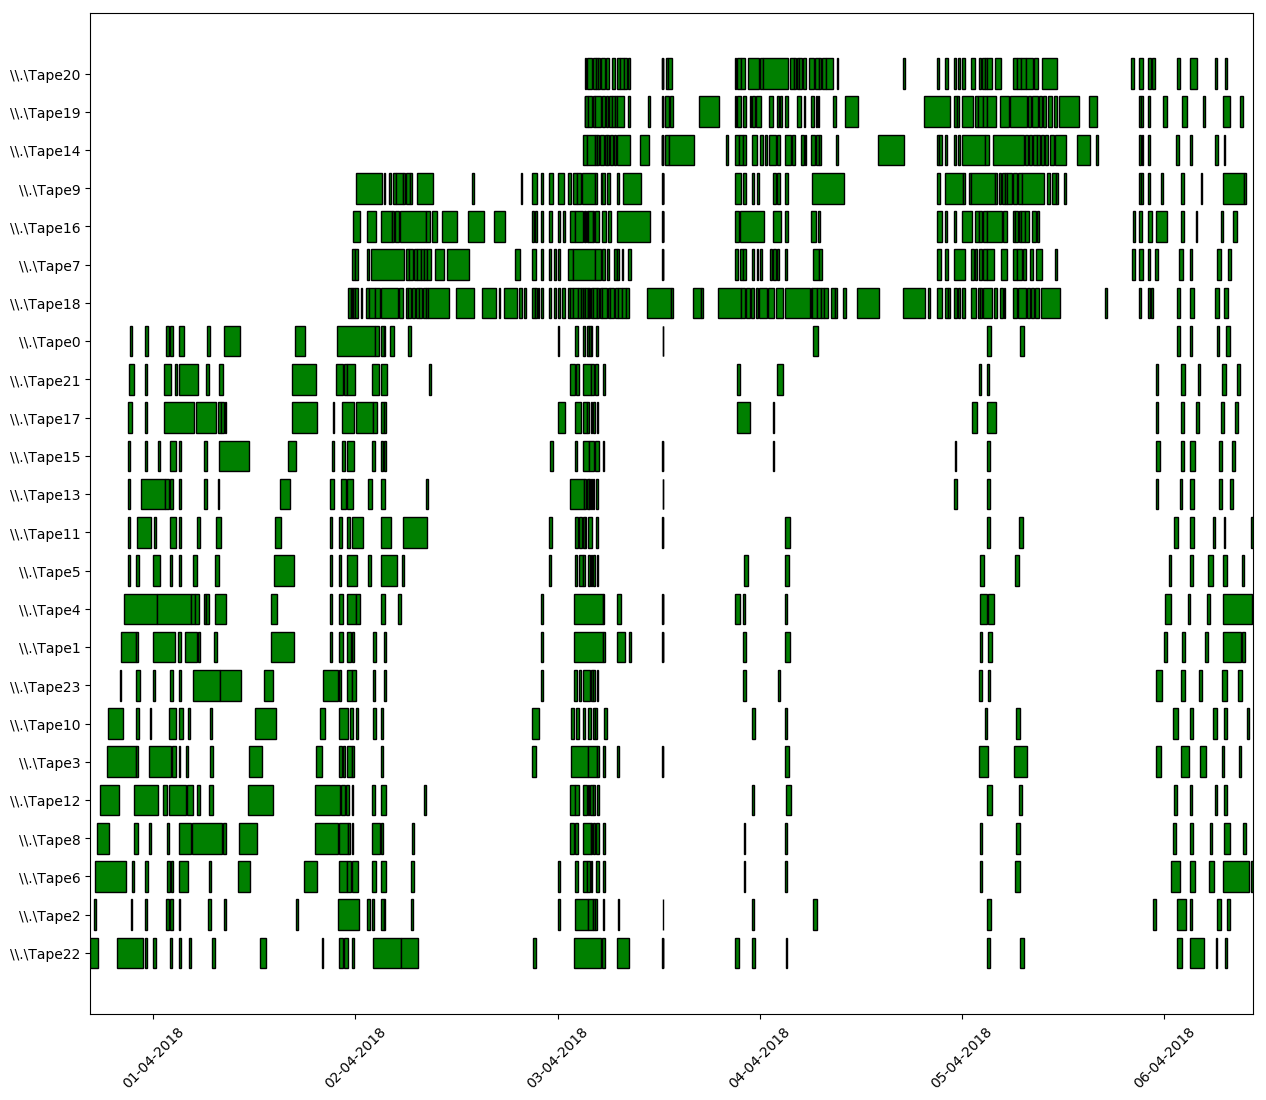

In [108]:
fig = plt.figure(figsize=(15,13))
ax1 = fig.add_subplot(111)

xtick = pd.date_range(drives.loading.min(), drives.unloading.max(), freq='D')
daysFmt = mdates.DateFormatter('%d-%m-%Y')
ax1.set_yticks(drvlist.num)
ax1.set_yticklabels(drvlist.drive)
ax1.set_xlim(drives.loading.min(), drives.unloading.max())
ax1.set_xticklabels(xtick,rotation=45)
ax1.xaxis.set_major_formatter(daysFmt)
for i in range(len(drives.session)):
    drv = drives[drives.session==i]
    ax1.barh(drv.num, drv.duration, left=drv.loading, color='green',edgecolor='black')

plt.show()

## ssets

In [118]:
minus = re.compile('(.+)done saving to pool.+')
equals = re.compile('.+\s[KMGT]B')

def count_save(row):
    if re.match(minus,row.log): res=-1
    elif re.match(equals,row.log): res=0
    else: res=1
    return res

filter = (log.program=='nsrd') & (log.log.str.contains("saving to pool"))
res = log.log[filter].reset_index()
res['cnt'] = res.apply(count_save,axis=1)

res = pd.concat([res[['date','cnt']],
                 res.log.str.split('saving|done|\'|\(|\)',expand=True)[[0,6]]],
                  axis=1).rename({0:'sset',6:'size'},axis=1)

range_session = {g:0 for g in res.sset.unique()}
def calcul_session(row):
    res = range_session[row.sset]
    if row.cnt==1: range_session[row.sset]+=1
    if row.cnt==-1: res = res-1
    if row.cnt==0: res=-1
    return res

res['session'] = res.apply(calcul_session,axis=1)
res = res[res.session!=-1]
res = res.groupby(['session','sset']).agg({'date': ['min', 'max'], 'size': 'last' },group_keys=False).reset_index()

resize = {'B':1,'KB':1e3,'MB':1e6,'GB':1e9,'TB':1e12}
def convert_size(row):
    try: res=int(row[1])*resize[row[2]]
    except ValueError: res=0
    return res


res['size'] = res['size']['last'].str.split(' ',expand=True).apply(convert_size,axis=1)

res = pd.concat([res,res.sset.str.split(':',n=1,expand=True)],axis=1)
res.columns = ['session','sset1','start','end','size','client','sset']
res['duration'] = res.apply(lambda row: row.end-row.start,axis=1)

ssets = res[['session','client','sset','start','duration','size']]
bandwith = ssets.resample('H',on='start').sum()['size'] / 1e12
sessions = ssets.resample('H',on='start').count()['session']

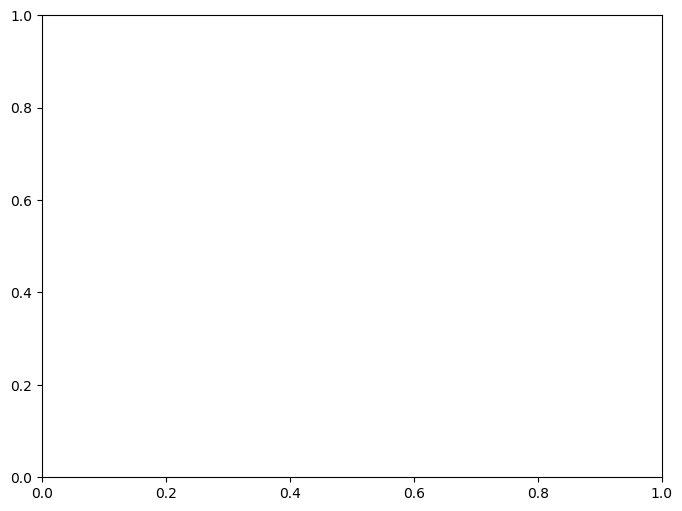

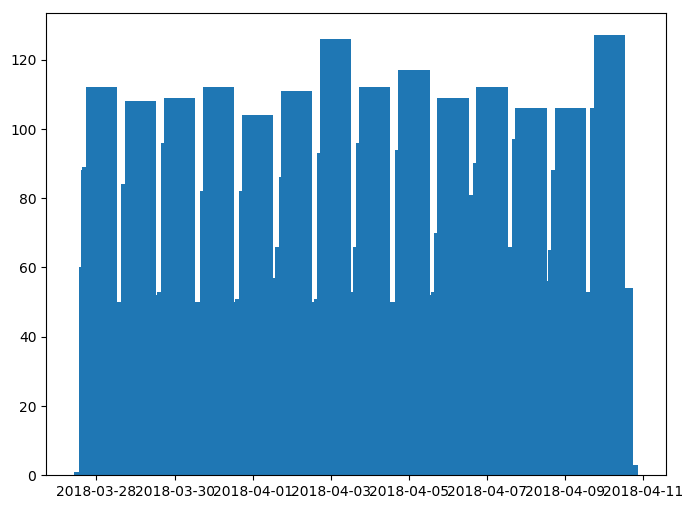

In [127]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(sessions.index,sessions)
plt.show()

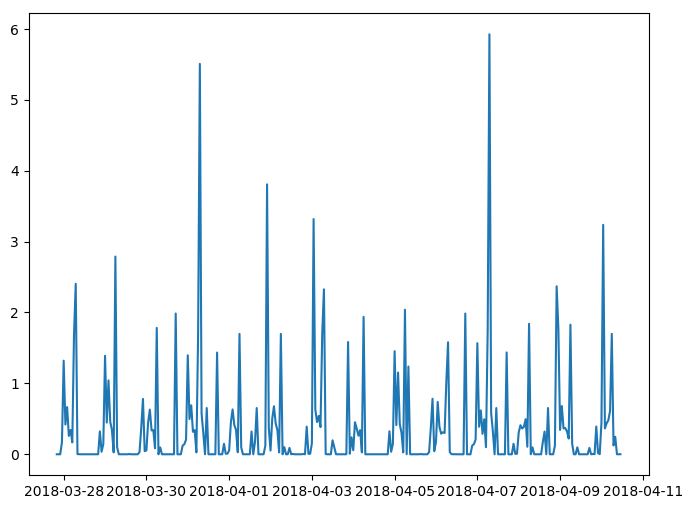

In [204]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(bandwith)
plt.show()

In [ ]:
ssets[ssets.session>40].groupby(['client','sset']).session.max()

In [ ]:
res = ssets.groupby(['client','sset'])['size'].max().reset_index().nlargest(10,'size')
res['size (GB)'] = ([int(x) for x in res['size'] / 1e9])
del res['size']
res

In [ ]:
res = ssets.groupby(['client','sset'])['duration'].max().reset_index().nlargest(10,'duration')
# res['size (GB)'] = ([int(x) for x in res['size'] / 1e9])
# del res['size']
res

## volumes

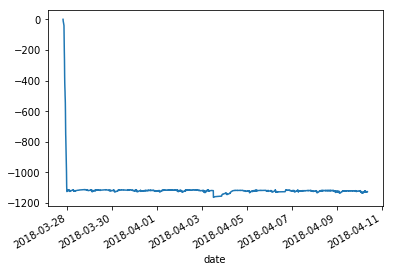

In [210]:
%matplotlib inline
deleted = re.compile('Deleted media Notice.+')
full = re.compile('.+is full.+')

def parse_medialog(row):
    res = 0
    if re.match(deleted,row.log): res = -1
    elif re.match(full,row.log): res = 1
    return res


filter = ((log.program=='nsrd') & (log.log.str.contains("[Mm]edia Notice")))
(log[filter].apply(parse_medialog,axis=1).cumsum()).plot() 

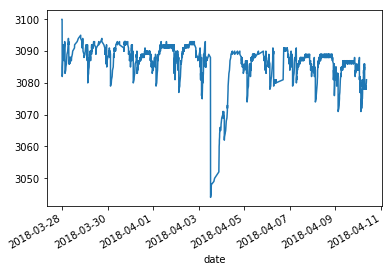

In [226]:
daterange = (log.index > '03/28/18') & (log.index < '04/11/18')
filter = (daterange & (log.program=='nsrd') & (log.log.str.contains("[Mm]edia Notice")))
(log[filter].apply(parse_medialog,axis=1).cumsum()+3100).plot() 